## Neural Net models

In [1]:
import tarfile
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import joblib

#import tensorflow as tf
from tensorflow import keras

# FFNN
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

# RNN
from keras.preprocessing import sequence
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM

In [2]:
data = pd.read_csv('data/newsArticlesWithLabelsAndText.csv')
data.sample(5)

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,source,date,author,title,text
4737,http://www.latimes.com/news/world/worldnow/la-...,News,0,International News,National Security,Neutral,Neutral,latimes,2013-07-02 07:00:00,"['Sergei L. Loiko Has Covered Wars', 'Crises',...",Kremlin: Edward Snowden revokes request for Ru...,MOSCOW -- Edward Snowden has withdrawn an appl...
1737,http://www.cnn.com/2013/11/28/politics/obamaca...,News,1,Healthcare,Economy,Neutral,Neutral,cnn,2013-11-28 00:00:00,['Tom Cohen'],The Obamacare question: Can the website handle...,Story highlights Saturday is the administratio...
6602,http://www.chicagotribune.com/news/local/ct-me...,News,1,Economy,None,Neutral,Neutral,chicagotribune,NaN,[],NaN,NaN
3797,http://www.reuters.com/article/2013/04/27/us-a...,News,1,National Security,International News,Neutral,Neutral,reuters,NaN,[],NaN,NaN
9461,http://edition.cnn.com/2013/06/22/world/europe...,News,0,National Security,None,Negative,SomewhatNegative,cnn,2013-06-22 00:00:00,['Laura Smith-Spark'],WikiLeaks' Julian Assange urges support for Sn...,Story highlights Assange says President Obama ...


In [3]:
sub = data.loc[data.perceived == 0]

In [4]:
sub['republican.vote'].unique()

array(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive',
       'Negative'], dtype=object)

In [5]:
train = pd.DataFrame()
train['left'] = sub['democrat.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,0,1,0])
train['right'] = sub['republican.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,0,1,0])
train['text'] = sub['text']
df = train.dropna()

In [6]:
df['text']

16       Cole is the Grammy-winning singer and daughter...
17       SACRAMENTO — “Living in parallel universes,” i...
18       Co-host of MSNBC's "The Cycle" Touré joined Hu...
22       Labor secretary nominee Thomas Perez cut a "se...
26       Story highlights Senior officials say Biden ap...
                               ...                        
10486    Way too late to avert scandal, the Internal Re...
10489    8 years ago\n\n(CNN) - New Jersey Democrat and...
10492    Ever since Christie cruised to reelection last...
10493    CHARLOTTE, N.C.—Republican National Committee ...
10496    WASHINGTON -- Former South Carolina Gov. Mark ...
Name: text, Length: 3840, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preclean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('\\s', ' ', text)
    text = re.sub(' +', ' ', text)
    #text = text.split(' ')
    return text

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub('\\s', ' ', text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    text = re.sub(' +', ' ', text)
    #text = text.split(' ')
    return text

tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=2000
)

In [8]:
from keras.utils import to_categorical

# preclean only
#X = df["text"].apply(lambda x: preclean_text(x))

tfidf_fit = tfidf.fit(df["text"])
X = tfidf_fit.transform(df["text"]).toarray()

#y = to_categorical(df["opinion"])
y = to_categorical(df['right'])
#y = to_categorical(df['left'])
#y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)
np.shape(y)

(3840, 2)

In [9]:
# Save model
#joblib.dump(tfidf_fit, 'models/tfidf_fit.pkl')

In [10]:
# FFNN Model
num_classes = 2

model = keras.Sequential()
# Input layer
model.add(Dense(2000, input_dim=2000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              4002000   
_________________________________________________________________
batch_normalization (BatchNo (None, 2000)              8000      
_________________________________________________________________
activation (Activation)      (None, 2000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0

In [11]:
# Fit and evaluate
batch_size = 128
epochs = 20

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/20
21/21 [==============================] - 9s 285ms/step - loss: 0.8540 - accuracy: 0.5128 - val_loss: 0.7702 - val_accuracy: 0.0716
Epoch 2/20
21/21 [==============================] - 4s 168ms/step - loss: 0.6881 - accuracy: 0.5830 - val_loss: 0.8506 - val_accuracy: 0.0716
Epoch 3/20
21/21 [==============================] - 3s 164ms/step - loss: 0.6407 - accuracy: 0.6660 - val_loss: 0.8664 - val_accuracy: 0.0716
Epoch 4/20
21/21 [==============================] - 4s 173ms/step - loss: 0.6045 - accuracy: 0.7392 - val_loss: 0.8969 - val_accuracy: 0.0716
Epoch 5/20
21/21 [==============================] - 4s 173ms/step - loss: 0.5557 - accuracy: 0.8075 - val_loss: 0.9481 - val_accuracy: 0.0716
Epoch 6/20
21/21 [==============================] - 3s 166ms/step - loss: 0.5216 - accuracy: 0.8273 - val_loss: 0.9901 - val_accuracy: 0.0716
Epoch 7/20
21/21 [==============================] - 3s 164ms/step - loss: 0.4760 - accuracy: 0.8599 - val_loss: 0.9164 - val_accuracy: 0.0716
Epoch 

In [12]:
#model.save('models/right_bias_model-FFNN_2000_500_100-epochs_20.h5')

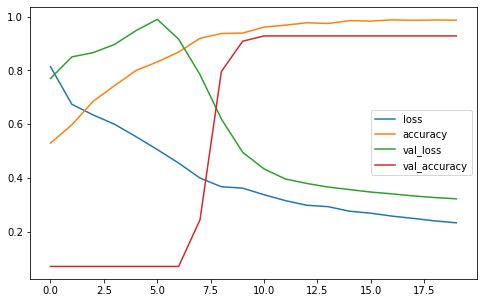

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab = 1000
max_len = 500

df["text"] = df["text"].apply(lambda x: clean_text(x))
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df["text"])
X = tfidf.fit_transform(df["text"]).toarray()
#y = to_categorical(df[["right","left"]])
y = to_categorical(df["right"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#np.shape(X_train)

<ipython-input-14-edb93c3c070d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(lambda x: clean_text(x))


In [15]:
# GRU Model
num_classes = 2

model = keras.Sequential()
# Input layer
model.add(Embedding(vocab, 128, input_length=max_len))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          128000    
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 235,458
Trainable params: 235,458
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fit and evaluate

batch_size = 64
epochs = 3

X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/3
41/41 [==============================] - 214s 5s/step - loss: 0.4771 - accuracy: 0.8357 - val_loss: 0.2589 - val_accuracy: 0.9284
Epoch 2/3
41/41 [==============================] - 198s 5s/step - loss: 0.2784 - accuracy: 0.9207 - val_loss: 0.2577 - val_accuracy: 0.9284
Epoch 3/3
41/41 [==============================] - 229s 6s/step - loss: 0.3039 - accuracy: 0.9102 - val_loss: 0.2596 - val_accuracy: 0.9284
Loss: 26.58
Accuracy: 92.58


In [17]:
#model.save('models/right_bias_model-GRU_128-epochs_5_acc.h5')

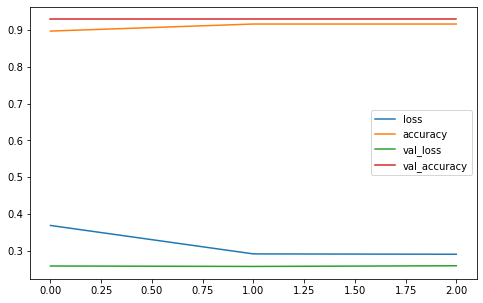

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5));

## TF-IDF / SVM models

In [19]:
op = pd.DataFrame()
op['opinion'] = sub['q3'].replace(['Opinion', 'News', 'other'], [1,0,np.nan])
op['text'] = sub['text']#.replace('NaN', np.nan)
df = op.dropna()
np.shape(df)

(3575, 2)

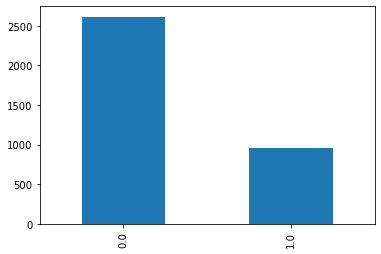

In [20]:
df.opinion.value_counts().plot(kind='bar');

In [21]:
#dx = df.drop(df['opinion'][df['opinion'] == 0].sample(frac=0.60, random_state=42).index)
#dx.opinion.value_counts().plot(kind='bar');

In [22]:
from keras.utils import to_categorical

tfidf_fit = tfidf.fit(df["text"])
X = tfidf_fit.transform(df["text"]).toarray()
y = df["opinion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)
#np.shape(y_train)

(2860, 2000)

In [23]:
# FFNN Model
num_classes = 1

model = keras.Sequential()
# Input layer
model.add(Dense(1000, input_dim=2000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_4 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               500500    
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
activation_5 (Activation)    (None, 500)              

In [24]:
# Fit and evaluate
batch_size = 128
epochs = 50

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/50
19/19 [==============================] - 6s 126ms/step - loss: 0.7802 - accuracy: 0.5209 - val_loss: 0.7090 - val_accuracy: 0.2960
Epoch 2/50
19/19 [==============================] - 2s 90ms/step - loss: 0.5883 - accuracy: 0.6927 - val_loss: 0.7590 - val_accuracy: 0.2564
Epoch 3/50
19/19 [==============================] - 2s 92ms/step - loss: 0.5326 - accuracy: 0.7661 - val_loss: 0.7876 - val_accuracy: 0.2564
Epoch 4/50
19/19 [==============================] - 2s 93ms/step - loss: 0.4763 - accuracy: 0.8483 - val_loss: 0.7879 - val_accuracy: 0.2564
Epoch 5/50
19/19 [==============================] - 2s 95ms/step - loss: 0.4560 - accuracy: 0.8635 - val_loss: 0.7955 - val_accuracy: 0.2564
Epoch 6/50
19/19 [==============================] - 2s 89ms/step - loss: 0.4102 - accuracy: 0.9345 - val_loss: 0.7889 - val_accuracy: 0.2564
Epoch 7/50
19/19 [==============================] - 2s 92ms/step - loss: 0.3958 - accuracy: 0.9430 - val_loss: 0.7922 - val_accuracy: 0.2564
Epoch 8/50
1

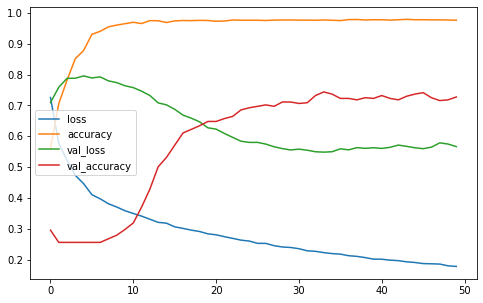

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [26]:
pred = model.predict(X_test)
predict = np.where(pred >= 0.5 , 1, 0)

In [27]:
# Evaluate
from sklearn import metrics
# y_test.argmax(axis=1) transform one-hot back to category 
print(metrics.confusion_matrix(y_test,predict))
print(metrics.classification_report(y_test,predict))

[[437  78]
 [107  93]]
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83       515
         1.0       0.54      0.47      0.50       200

    accuracy                           0.74       715
   macro avg       0.67      0.66      0.66       715
weighted avg       0.73      0.74      0.73       715



In [28]:
X = df["text"]
y = df["opinion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)

(2860,)

In [29]:
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return  X.apply(lambda text: " ".join([self.lemmatizer.lemmatize(word) for word in text.split()]))

In [30]:
import numpy as np
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.base import TransformerMixin, BaseEstimator

class Doc2Vec(BaseEstimator, TransformerMixin):
    def __init__(self, nlp, doc='doc'):
        self.doc = doc
        self.nlp = nlp

    def fit(self, X, y):
        return self

    def transform(self, X):
        if self.doc == 'word':
            # return a vector for each word
            # need more work
            vec = X.apply(lambda text: np.array([self.nlp(w).vector for w in text]) )
        elif self.doc == 'sentense':
            # return a vector for each sentense
            # need more work
            vec = X.apply(lambda text: np.array([self.nlp(s).vector for s in text.split('.')]) )
        else:
            # return a vector for the whole doc 
            vec = X.apply(lambda text: np.array(self.nlp(text).vector))
            #vec = np.array([self.nlp(text).vector for text in X])
        return  pd.DataFrame(vec.values.tolist(), index=vec.index)

In [31]:
X_train

5074     Don’t we need to do a lot more about our socia...
8767     David Jackson\n\nUSA TODAY\n\nPresident Obama ...
6519     President Biden is introducing a policy that w...
345      8 years ago\n\nWashington (CNN) – Scroll throu...
7654     Polling numbers are starting to roll in after ...
                               ...                        
2988     The California Senate on Wednesday approved a ...
3416     You may have heard that White House tours were...
2299     Senate Democrats are considering holding a vot...
10230    HONOLULU — President Obama celebrated a low-ke...
9035     Protestors in South Africa, thought to be affi...
Name: text, Length: 2860, dtype: object

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

pipe_lsvc = Pipeline([
    ('lemma', Lemmatizer()),
    ('tfidf', TfidfVectorizer(preprocessor=clean_text)),
    #('scale', MaxAbsScaler()),
    #('norm', Normalizer()),
    #('d2v', Doc2Vec(nlp)),
    ('svc', SVC(probability=True))
    #('lsvc', LinearSVC())
])

# final set of parameters after formal grid search
param_grid_lsvc = [{
    'tfidf__max_df': [0.95],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1, 2)],
    'svc__kernel': ['linear'], # 'rbf' require scaling
    'svc__C': [0.75],
}]

grid_svc = GridSearchCV(pipe_lsvc, param_grid_lsvc, 
                    scoring='accuracy', 
                    cv=5,
                    n_jobs=5,
                    verbose=3)

grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)
print(grid_svc.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.5min finished
{'svc__C': 0.75, 'svc__kernel': 'linear', 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
0.7958041958041958


In [33]:
# Save model
#joblib.dump(grid_svc, 'models/opinion_tfidf_svc_2000_acc_78_prob.pkl')

In [34]:
from sklearn import metrics
pred = grid_svc.predict(X_test)
#predict = np.where(pred >= 0.5 , 1, 0)
print(metrics.confusion_matrix(y_test,pred))
print(metrics.classification_report(y_test,pred))

[[483  32]
 [128  72]]
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       515
         1.0       0.69      0.36      0.47       200

    accuracy                           0.78       715
   macro avg       0.74      0.65      0.67       715
weighted avg       0.76      0.78      0.75       715



In [35]:
grid_svc.predict_proba(X_test)

array([[0.72739752, 0.27260248],
       [0.37361637, 0.62638363],
       [0.79850187, 0.20149813],
       ...,
       [0.82665236, 0.17334764],
       [0.15454486, 0.84545514],
       [0.81386176, 0.18613824]])

In [36]:
train = pd.DataFrame()
train['left'] = sub['democrat.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,0,1,0])
train['right'] = sub['republican.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,0,1,0])
train['text'] = sub['text']
dz = train.dropna()

In [37]:
X = dz["text"]
#y = dz["right"]
y = dz["left"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)

(3072,)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

pipe_lsvc = Pipeline([
    ('lemma', Lemmatizer()),
    ('tfidf', TfidfVectorizer(preprocessor=clean_text)),
    #('scale', MaxAbsScaler()),
    #('norm', Normalizer()),
    #('d2v', Doc2Vec(nlp)),
    ('svc', SVC(probability=True))
    #('lsvc', LinearSVC())
])

# final set of parameters after formal grid search
param_grid_lsvc = [{
    'tfidf__max_df': [0.95],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1, 2)],
    'svc__kernel': ['linear'], # 'rbf' require scaling
    'svc__C': [0.75],
}]

grid_svc = GridSearchCV(pipe_lsvc, param_grid_lsvc, 
                    scoring='accuracy', 
                    cv=5,
                    n_jobs=5,
                    verbose=3)

grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)
print(grid_svc.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.1min finished
{'svc__C': 0.75, 'svc__kernel': 'linear', 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
0.8642583618018591


In [39]:
# Save model
#joblib.dump(grid_svc, 'models/right_bias_tfidf_svc_2000_acc_93_prob.pkl')
#joblib.dump(grid_svc, 'models/left_bias_tfidf_svc_2000_acc_86_prob.pkl')